# Keras starter kit [full training set, UNet]

## Setup

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from tqdm import tqdm
import cv2

# Data config
# DATA_DIR = '/kaggle/input/vesuvius-challenge-ink-detection/'
DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
BUFFER = 128  # Half-size of papyrus patches we'll use as model inputs
Z_LIST = list(range(0, 65, 3))  # Offset of slices in the z direction
Z_DIM = len(Z_LIST)  # Number of slices in the z direction. Max value is 64 - Z_START
SHARED_HEIGHT = 4000  # Height to resize all papyrii

# (y, x)
val_location = (600, 1000)
# val_location = (600, 500)
val_zone_size = (1000, 2000)

# Model config
BATCH_SIZE = 64
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

device = torch.device("cuda")
threshold = 0.5
num_workers = 4
exp = 1e-7

num_epochs = 30
lr = 1e-4

pytorch_lightning.seed_everything(seed=42)
torch.set_float32_matmul_precision('high')

Global seed set to 42


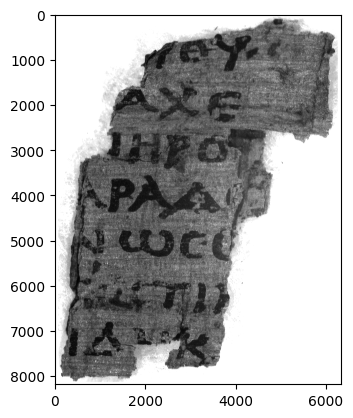

In [2]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")

## Load up the training data

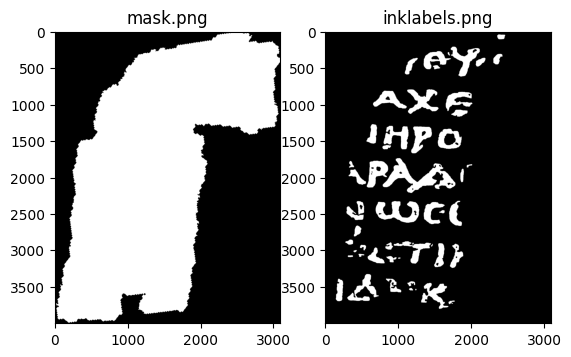

In [3]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255
    img = resize(img)    
    return img


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img


mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [4]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

mask_test_a: (4000, 9284)
mask_test_b: (4000, 4642)
-
mask_train_1: (4000, 3094)
labels_train_1: (4000, 3094)
-
mask_train_2: (4000, 2563)
labels_train_2: (4000, 2563)
-
mask_train_3: (4000, 2760)
labels_train_3: (4000, 2760)


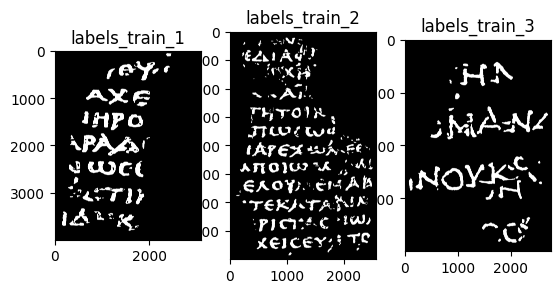

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

In [6]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    all = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))
    z_slices_fnames = [all[i] for i in range(len(all)) if i in Z_LIST]
    assert len(z_slices_fnames) == Z_DIM
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        img = resize(img)
        img = (img / (2 ** 8)).astype(np.uint8)
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

In [7]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

22it [00:02,  8.70it/s]


volume_train_1: (4000, 3094, 22), uint8


22it [00:05,  3.89it/s]


volume_train_2: (4000, 2563, 22), uint8


22it [00:01, 11.50it/s]


volume_train_3: (4000, 2760, 22), uint8
total volume: (4000, 8417, 22)


In [8]:
del volume_train_1
del volume_train_2
del volume_train_3

In [9]:
labels = np.concatenate([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")
mask = np.concatenate([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

labels: (4000, 8417), uint8
mask: (4000, 8417), uint8


In [10]:
# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

## Visualize the training data

In this case, not very informative. But remember to always visualize what you're training on, as a sanity check!

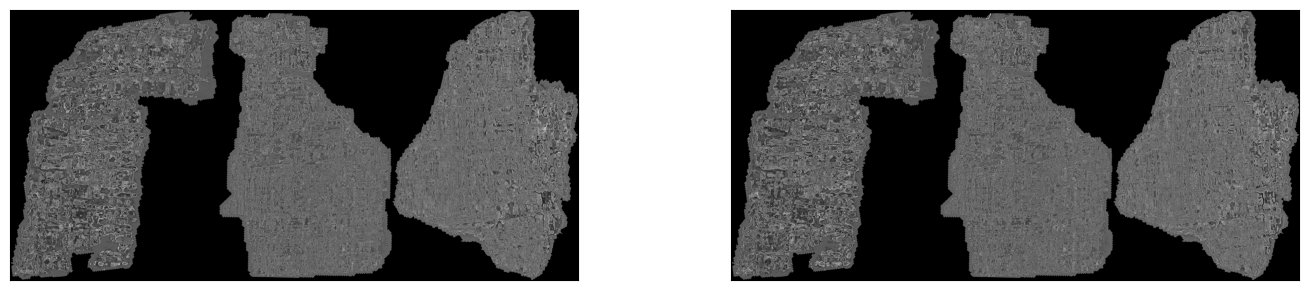

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

## Selection a validation holdout area

We set aside some fraction of the input to validate our model on.

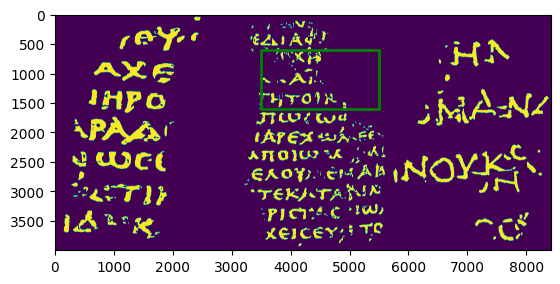

In [12]:
fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

## Create a dataset that samples random locations in the input volume

Our training dataset will grab random patches within the masked area and outside of the validation area.

In [13]:
def sample_random_location(shape):
    random_train_x = np.random.randint(low=BUFFER, high=shape[1] - BUFFER - 1, size=())
    random_train_y = np.random.randint(low=BUFFER, high=shape[0] - BUFFER - 1, size=())
    random_train_location = np.stack([random_train_y, random_train_x], axis=-1)
    return random_train_location


def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]] > 0

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[1]
    y = location[0]
    x_match = val_location[1] - BUFFER <= x <= val_location[1] + val_zone_size[1] + BUFFER
    y_match = val_location[0] - BUFFER <= y <= val_location[0] + val_zone_size[0] + BUFFER
    return x_match and y_match

In [14]:

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

In [15]:
sample_random_location_train = lambda x: sample_random_location(volume.shape[:-1])
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

# Create a list to store train locations
train_locations = []

# Define the number of train locations you want to generate
num_train_locations = 4000

# Generate train locations
while len(train_locations) < num_train_locations:
    location = sample_random_location_train(0)
    if is_proper_train_location(location):
        train_locations.append(location)

# Convert the list of train locations to a PyTorch tensor
train_locations_ds = np.stack(train_locations, axis=0)

## Visualize some training patches

Sanity check visually that our patches are where they should be.

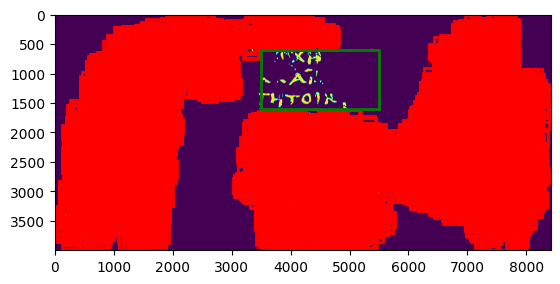

In [16]:
fig, ax = plt.subplots()
ax.imshow(labels)

# Define the number of samples you want to take from train_locations_ds
num_samples = 4000

# Iterate over the first 'num_samples' elements in train_locations_ds
for i in range(num_samples):
    y, x = train_locations_ds[i]
    patch = Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [17]:
from scipy.stats import median_abs_deviation
all_MAD = median_abs_deviation(volume, axis=[0, 1])

In [18]:
all_median = np.median(volume, axis=[0, 1])

In [19]:
mean = np.mean(volume)

In [20]:
mean

61.385962810653766

In [21]:
std = np.std(volume)

In [22]:
std

51.75140138792272

In [23]:
possible_max_input = ((2 ** 16 - 1) / all_median.min())
possible_max_input

949.7826086956521

In [24]:
print("all_median", all_median)
"all_median", all_median

all_median [76. 76. 76. 76. 76. 77. 78. 81. 85. 88. 82. 71. 69. 76. 82. 86. 88. 89.
 90. 90. 90. 91.]


('all_median',
 array([76., 76., 76., 76., 76., 77., 78., 81., 85., 88., 82., 71., 69.,
        76., 82., 86., 88., 89., 90., 90., 90., 91.]))

In [25]:
print("all_MAD", all_MAD)
"all_MAD", all_MAD

all_MAD [49. 49. 50. 50. 51. 51. 51. 51. 53. 56. 58. 47. 29. 21. 16. 13. 12. 11.
 10. 10. 10. 10.]


('all_MAD',
 array([49., 49., 50., 50., 51., 51., 51., 51., 53., 56., 58., 47., 29.,
        21., 16., 13., 12., 11., 10., 10., 10., 10.]))

In [26]:
all

<function all(iterable, /)>

In [27]:
printed = False

def extract_subvolume(location, volume):
    global printed
    # print(np.unique(volume, return_counts=True, return_index=True))
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :].astype(np.float32)
    # print("subvolume[:, :, 0]", subvolume[:, :, 0])
    median = np.full_like(subvolume, all_median).astype(np.float32)
    MAD = np.full_like(subvolume, all_MAD).astype(np.float32)
    # mean = np.mean(subvolume, axis=2)
    # mean = np.stack([mean for i in range(Z_DIM)], axis=2) + exp
    # MAD = median_abs_deviation(subvolume, axis=2)
    # print("MAD", MAD[0, 0, :])
    # print("mean", mean)
    # print("median", median[0, 0, :])
    
    subvolume = (subvolume / median)
    
    if not printed:
        print("subvolume after taking care of median and MAD", subvolume)
        printed = True
    
    return subvolume

## Create training dataset that yields random subvolumes and their labels

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool, return_location: bool = False):
        self.locations = locations
        self.volume = volume
        self.labels = labels        
        self.buffer = buffer
        self.is_train = is_train
        self.return_location = return_location

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        label = None
        location = np.array(self.locations[idx])
        y, x = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)        
        # print("subvolume", subvolume)
        # print("labels", labels)
        # subvolume = subvolume.numpy()
        subvolume = subvolume
        
        if self.labels is not None:
            label = self.labels[y - self.buffer:y + self.buffer, x - self.buffer:x + self.buffer]
            # print("label", label)
            # n_category = 2
            # label = np.eye(n_category)[label]
            label = np.stack([label], axis=-1)
            # label = label.numpy()
            # print("label.shape", label.shape
        
        if self.is_train and label is not None:            
            
            # print("label", label.dtype)
            # print("subvolume in dataset (before aug)", subvolume)    
            size = int(BUFFER * 2)
            performed = A.Compose([            
                # A.ToFloat(max_value=possible_max_input),
                A.HorizontalFlip(p=0.5), # 水平方向に反転
                A.VerticalFlip(p=0.5), # 水平方向に反転
                A.ShiftScaleRotate(p=1, border_mode=0), # シフト、スケーリング、回転
                # A.PadIfNeeded(min_height=size, min_width=size, always_apply=True, border_mode=0), # 必要に応じてパディングを追加
                # A.RandomCrop(height=size, width=size, always_apply=True), # ランダムにクロップ, Moduleの中で計算する際に次元がバッチ内で揃っている必要があるので最後にサイズは揃える
                A.Perspective(p=0.5), # パースペクティブ変換
                A.OneOf([
                    A.GaussNoise(var_limit=[10, 50]),
                    A.GaussianBlur(),
                    A.MotionBlur(),
                ], p=0.4),
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
                A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                                mask_fill_value=0, p=0.5),
                # A.OneOf(
                #     [
                #         A.Sharpen(p=1),
                #         A.Blur(blur_limit=3, p=1),
                #         A.MotionBlur(blur_limit=3, p=1),
                #     ],
                #     p=0.9,
                # ),
                A.Resize(BUFFER * 2, BUFFER * 2, always_apply=True),
                # A.Normalize(
                #     mean= [0] * Z_DIM,
                #     std= [1] * Z_DIM
                # ),
                # A.FromFloat(),
            ])(image=subvolume, mask=label)            
            subvolume = performed["image"]            
            label = performed["mask"]
            # print("subvolume in dataset (after aug)", subvolume)
            # print("label", label.dtype)
            # print("subvolume", subvolume.dtype)
            # →C, H, W
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float32))
            # print(performed)
            # print(subvolume.shape, label.shape)
            # H, W, C → C, H, W
            label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        else:
            performed = A.Compose([            
                # A.Normalize(
                #     mean= [0] * Z_DIM,
                #     std= [1] * Z_DIM
                # ),
            ])(image=subvolume)
            subvolume = performed["image"]
            subvolume = torch.from_numpy(subvolume.transpose(2, 0, 1).astype(np.float32))
            if label is not None:
                label = torch.from_numpy(label.transpose(2, 0, 1).astype(np.uint8)) 
        if self.return_location:
            return subvolume, location
        return subvolume, label        

In [29]:

# Convert train_locations_ds to a PyTorch tensor
train_locations_tensor = np.stack([x for x in train_locations_ds], axis=0)

# Create an instance of the SubvolumeDataset
train_ds = SubvolumeDataset(train_locations_tensor, volume, labels, BUFFER, is_train=True)


In [30]:
# Create a DataLoader with the dataset
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

In [31]:
subvolume_batch, label_batch = train_ds[1]
print(f"subvolume shape: {subvolume_batch.shape}")
print(f"label_batch shape: {label_batch.shape}")

subvolume after taking care of median and MAD [[[1.0789474  1.7105263  2.1578948  ... 1.0555556  1.0444444  0.9120879 ]
  [1.2368422  2.0263157  2.1973684  ... 1.0111111  1.0444444  0.9230769 ]
  [1.3684211  2.         2.1447368  ... 1.         1.0666667  0.94505495]
  ...
  [0.18421052 0.36842105 0.23684211 ... 1.         1.0222223  0.978022  ]
  [0.2631579  0.84210527 0.47368422 ... 1.0222223  1.0444444  1.        ]
  [0.6052632  0.38157895 0.55263156 ... 1.0222223  1.0222223  1.0109891 ]]

 [[1.0526316  1.4736842  2.1578948  ... 0.98888886 1.0111111  0.96703297]
  [1.5657895  1.9868422  2.4210527  ... 0.9777778  1.0444444  0.978022  ]
  [2.1842105  2.0526316  2.3552632  ... 0.96666664 1.0444444  0.989011  ]
  ...
  [1.5789474  1.7631578  0.81578946 ... 1.0111111  1.0333333  0.96703297]
  [0.84210527 1.5789474  1.3552631  ... 1.0222223  1.0333333  1.0109891 ]
  [0.9736842  0.7631579  1.5921053  ... 1.0222223  1.0555556  1.0549451 ]]

 [[0.47368422 0.8684211  2.0131578  ... 0.96666664

## Check dataset throughput

It's always a good idea to check that your data pipeline is efficient. You don't want to be CPU-bound at training time!

In [32]:
# t0 = time.time()
# n = 200
# for _ in train_ds:
#     pass
# print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

## Create validation dataset

In [33]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

# Convert the list of val locations to a PyTorch tensor
val_locations_ds = np.stack(val_locations, axis=0)

# Create an instance of the SubvolumeDataset
val_ds = SubvolumeDataset(val_locations_ds, volume, labels, BUFFER, is_train=False)

# Create a DataLoader with the dataset
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

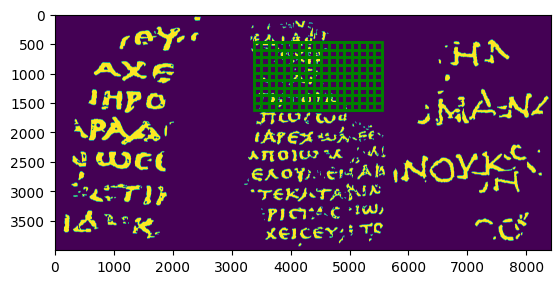

In [34]:
fig, ax = plt.subplots()
ax.imshow(labels)

for y, x in val_locations_ds:
    patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

In [35]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        batch_label = torch.tensor(batch_label)
        matches += torch.sum(batch_label.float())
        total += torch.numel(batch_label)
    return 1. - matches / total

score = trivial_baseline(val_ds).item()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

  0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipykernel_3881957/1352218617.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_label = torch.tensor(batch_label)
100%|██████████| 128/128 [00:00<00:00, 443.69it/s]

Best validation score achievable trivially: 91.09% accuracy


## Augment the training data

## Train a Keras model

This model is a U-Net taken from [this segmentation tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

`model.fit()` goes brrrrr

Conceptually it looks like this (animation from [this tutorial](https://www.kaggle.com/code/jpposma/vesuvius-challenge-ink-detection-tutorial)):

![animation](https://user-images.githubusercontent.com/22727759/224853385-ed190d89-f466-469c-82a9-499881759d57.gif)

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

In [37]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:

class Model(pl.LightningModule):
    
    training_step_outputs = []
    validation_step_outputs = []
    test_step_outputs = []
        

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name, 
            encoder_weights="imagenet",
            encoder_depth=5,
            decoder_channels=[512, 256, 128, 64, 32],
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        # self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        # self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        # image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        subvolumes, labels = batch
        
        image, mask = subvolumes.float(), labels.float()
        labels = labels.squeeze(dim=1)
        # print("torch.unique(subvolumes)", torch.unique(subvolumes), file=open("subvolumes_unique", "w"))

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > threshold).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        out = self.shared_step(batch, "train")
        self.training_step_outputs.append(out)
        return out

    def on_train_epoch_end(self):
        out = self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()
        return out

    def validation_step(self, batch, batch_idx):
        out = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(out)        
        return out

    def on_validation_epoch_end(self):
        out = self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return out

    def test_step(self, batch, batch_idx):
        global predictions_map

        patch_batch, loc_batch = batch
        
        loc_batch = loc_batch.long()
        patch_batch = patch_batch.float()
        predictions: torch.Tensor = self.forward(patch_batch)
        # print("predictions.shape", predictions.shape)
        # print("predictions", predictions)
        predictions = predictions.sigmoid()
        # print("Softmaxed predictions where conf is gt threshold", predictions[predictions.gt(threshold)])
        # print("predictions.shape after sigmoid", predictions.shape)
        # →(BATCH, W, H, C)
        predictions = torch.permute(predictions, (0, 3, 2, 1))
        predictions = predictions.cpu().numpy()  # move predictions to cpu and convert to numpy
        for (y, x), pred in zip(loc_batch, predictions):
            # print("index: ", index ,"x, y, pred", x.item(), y.item(), pred[BUFFER, BUFFER, :].item(), file=open('log.out', 'a'))
            predictions_map[
                x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :
            ][pred > threshold] = 1
        self.test_step_outputs.append(predictions)
        return predictions

    def on_test_epoch_end(self):
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_dataset_iou"}


In [39]:
import os
import torch.optim.lr_scheduler

# Define the model
fine_tune = True

if fine_tune:
    model = Model.load_from_checkpoint(
        "lightning_logs/version_4/checkpoints/epoch=29-step=960.ckpt",
        encoder_name="resnet101",
        in_channels=Z_DIM,
        out_classes=1,
    )
else:
    model = Model(
        encoder_name="resnet101",
        in_channels=Z_DIM,
        out_classes=1,
    )


In [40]:
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    max_epochs=num_epochs,
)

/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fummicc1/anaconda3/envs/ink-detection-3_8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `

In [41]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=val_dataloader,
)

RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

## Clear up memory

In [ ]:
# del volume
# del mask
# del labels
# del train_ds
# del val_ds

import gc
gc.collect()

## Compute predictions on test data

In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from skimage.transform import resize as resize_ski
import pathlib

predictions_map = None

def compute_predictions_map(split, index):
    global predictions_map
    
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)    

    test_locations = []
    stride = BUFFER // 2
    for y in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for x in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((y, x))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # filter locations inside the mask
    test_locations = [loc for loc in test_locations if is_in_masked_zone(loc, test_mask)]
    
    print(f"{len(test_locations)} test locations (after filtering by mask)")

    test_ds = SubvolumeDataset(test_locations, test_volume, None, BUFFER, is_train=False, return_location=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=num_workers)        

    # shape: (X, Y, C)
    predictions_map = np.zeros_like(test_volume[:, :, 0]).transpose((1, 0))[:, :, np.newaxis].astype(np.float64)

    # print("test_volume.shape", test_volume.shape)
    # print("predictions_map.shape", predictions_map.shape)

    # print(f"Compute predictions")
    
    model = Model.load_from_checkpoint(
        "lightning_logs/version_4/checkpoints/epoch=29-step=960.ckpt",
        encoder_name="resnet101",
        in_channels=Z_DIM,
        out_classes=1,
    )

    trainer = pl.Trainer(
        accelerator="gpu",
        devices="1",
        max_epochs=num_epochs,
    )

    trainer.test(
        model=model,
        dataloaders=test_loader,
        verbose=True,
    )
    # print("predictions_map", predictions_map, file=open("predictions_map", "w"))
    return predictions_map


In [ ]:
def rle(predictions_map, threshold):
    flat_img = (np.where(predictions_map.flatten() >= threshold, 1, 0)).astype(np.uint8)
    
    # Add padding at the beginning and end
    flat_img = np.pad(flat_img, pad_width=1, mode='constant', constant_values=0)

    starts = np.where((flat_img[:-1] == 0) & (flat_img[1:] == 1))[0]
    ends = np.where((flat_img[:-1] == 1) & (flat_img[1:] == 0))[0]

    lengths = ends - starts

    return " ".join(map(str, np.c_[starts, lengths].flatten()))


In [ ]:
def update_submission(predictions_map, index):
    rle_ = rle(predictions_map, threshold=threshold)
    print(f"{index}," + rle_, file=open('submission.csv', 'a'))
    # print(f"{index}," + rle_, file=open('/kaggle/working/submission.csv', 'a'))

## Resize prediction maps to their original size (for submission)

In [ ]:
print("Id,Predicted", file=open('submission.csv', 'w'))
kind = "test"
folder = pathlib.Path(DATA_DIR) / kind
for p in list(folder.iterdir()):
    index = p.stem
    predictions_map = compute_predictions_map(split=kind, index=index)
    original_size = cv2.imread(DATA_DIR + f"/{kind}/{index}/mask.png", 0).shape[:2]
    # W, H, C → H, W, C
    predictions_map = predictions_map.transpose((1, 0, 2))    
    predictions_map = resize_ski(predictions_map, (original_size[0], original_size[1], 1)).squeeze(axis=-1)    
    print("original predictions_map size", predictions_map.shape)    
    # H, W → W, H
    update_submission(predictions_map, index)
    plt.imsave(f"{index}.png", predictions_map, cmap="gray")